<a href="https://colab.research.google.com/github/tristanpadiou/Travel-assistant/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install langchain_google_genai
! pip install langchain-community
! pip install langgraph
! pip install pyowm
! pip install wikipedia
# ! pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=6114b352f1daaab13b3643bb3f56abe10ff78bdb7abb3235f21ec8d4168f5cbd
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [3]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

#structuring
import ast

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
# import gradio as gr


In [4]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
pse=userdata.get('programmable_search_engine')
OPENWEATHERMAP_API_KEY=userdata.get('open_weather_key')
os.environ['OPENWEATHERMAP_API_KEY']=OPENWEATHERMAP_API_KEY

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
parser = JsonOutputParser()

In [5]:
GEMINI_MODEL='gemini-1.5-flash'

In [6]:
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [7]:
@tool
def trip_data_loader(tool_call_id: Annotated[str, InjectedToolCallId],filename: str) -> str:
  """
  Tool to load the trip_data, which is a pickle file.

  Include the extensions in filename. eg. file.pkl.
  """
  # with open(f'/content/drive/MyDrive/{filename}', 'rb') as f:
  #   trip_data=pickle.load(f)
  if filename=='trip_data.pkl':
    trip_data=trip_schedule
    return Command(update={'trip_data':str(trip_data),
                            'messages':[ToolMessage('uploaded the trip_data', tool_call_id=tool_call_id)
                                        ]})


In [54]:
@tool
def schedule_creator(tool_call_id: Annotated[str, InjectedToolCallId], query:str)->str:
  """Tool to create or add a schedule from the chat query with the agent
  and then uses an llm to structure it.
  args: query - the query from the chat
  """
  
  prompt = PromptTemplate(
  template='create a schedule based on the query in a json format in the output, only include the json, no descriptions, do not include ```json```, do not include comments either',
  input_variables=["query"],
  partial_variables={"format_instructions": parser.get_format_instructions()},
  )
  chain = prompt | llm | parser

  result=chain.invoke({"query": query})
  
  return Command(update={'trip_data': result,
                          'messages':[ToolMessage('added a schedule from the chat', tool_call_id=tool_call_id)
                                      ]})



In [55]:
# initializing time and date tool

#creating a schema
class time_tool_schema(BaseModel):
  continent: str = Field(description='continent')
  city: str = Field(description='city')

def date_time_tool(continent: str,city: str) -> str:
  """
  tool to get the current date and time in a city.

  """
  city=city.replace(' ','_')
  query=continent+'/'+city
  timezone = pytz.timezone(query)
  # Get the current time in UTC, and then convert it to the Marrakech timezone
  utc_now = datetime.now(pytz.utc)  # Get current time in UTC
  localized_time = utc_now.astimezone(timezone)  # Convert to Marrakech time
  time=localized_time.strftime('%Y-%m-%d %H:%M:%S')
  return time

current_date_time_tool=StructuredTool.from_function(name='current_date_time_tool', func=date_time_tool, description='To get the current date and time in any city',args_schema=time_tool_schema, return_direct=True)


In [24]:
def google_image_search(query: str) -> str:
  """Search for images using Google Custom Search API
  args: query
  return: image url
  """
  # Define the API endpoint for Google Custom Search
  url = "https://www.googleapis.com/customsearch/v1"

  params = {
      "q": query,
      "cx": pse,
      "key": GOOGLE_API_KEY,
      "searchType": "image",  # Search for images
      "num": 1  # Number of results to fetch
  }

  # Make the request to the Google Custom Search API
  response = requests.get(url, params=params)
  data = response.json()

  # Check if the response contains image results
  if 'items' in data:
      # Extract the first image result
      image_url = data['items'][0]['link']
      return image_url
  else:
      return "Sorry, no images were found for your query."

google_image_tool=Tool(name='google_image_tool', func=google_image_search, description='Use this tool to search for images using Google Custom Search API')

In [25]:
@tool
def get_schedule(state: Annotated[dict, InjectedState])-> str:
  """
  Use this tool to get the information about the schedule once it has been loaded.
  args: none
  return: schedule
  """
  return state['trip_data']


In [61]:
# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]
  trip_data: dict




In [78]:
@tool
def schedule_editor(updates:str,state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId])-> str:
  """
  Tool to edit the schedule.
  Pass the updates to the llm to edit the schedule.
  args: updates - the updates to edit the schedule.
  """
  file=state['trip_data']
  prompt = PromptTemplate(
  template='Edit this schedule: {schedule_data} following the instructions in the query, and include the changes in the schedule, but dont mention them specifically, only include the updated schedule in json format in the output, do not include ```json```, do not include comments either',
  input_variables=["schedule_data","query"],
  partial_variables={"format_instructions": parser.get_format_instructions()},
  )
  chain = prompt | llm | parser

  result=chain.invoke({'schedule_data':str(file),"query": updates})
  return Command(
                 update={'trip_data':result,
                          'messages':[ToolMessage('edited the schedule', tool_call_id=tool_call_id)
                                      ]})

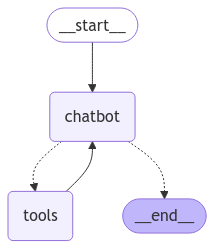

In [79]:
# langgraph
#loading tools
api_tools=load_tools(['openweathermap-api','wikipedia'])
langgraph_tools=[current_date_time_tool,google_image_tool,get_schedule,trip_data_loader,schedule_creator, schedule_editor]+api_tools



graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(langgraph_tools)

def chatbot(state: State):
  """ travel assistant that answers user questions about their trip.
  Depending on the request, leverage which tools to use if necessary."""
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=langgraph_tools)
graph_builder.add_node("tools", tool_node)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
memory=MemorySaver()
graph = graph_builder.compile(checkpointer=memory)



display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [86]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content=f"show me the updated schedule ")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

show me the updated schedule 
================================== Ai Message ==================================
Tool Calls:
  get_schedule (1acd8a03-a03f-4de4-a270-2d1edcecf051)
 Call ID: 1acd8a03-a03f-4de4-a270-2d1edcecf051
  Args:
================================= Tool Message =================================
Name: get_schedule

{"Monday": {"09:00": "eating", "12:00": "lunch", "18:00": "sleep"}, "Tuesday": {"09:00": "fight", "12:00": "flight", "18:00": "sleep"}}
================================== Ai Message ==================================

Here's your updated schedule:

**Monday:**

* 9:00 am: eating
* 12:00 pm: lunch
* 6:00 pm: sleep

**Tuesday:**

* 9:00 am: fight
* 12:00 pm: flight
* 6:00 pm: sleep


In [84]:
loll=graph.get_state(config).values["trip_data"]

In [85]:
loll

{'Monday': {'09:00': 'eating', '12:00': 'lunch', '18:00': 'sleep'},
 'Tuesday': {'09:00': 'fight', '12:00': 'flight', '18:00': 'sleep'}}

In [ ]:
def travel_agent(query,history):
  history_langchain_format = []
  for msg in history:
      if msg['role'] == "user":
          history_langchain_format.append(HumanMessage(content=msg['content']))
      elif msg['role'] == "assistant":
          history_langchain_format.append(AIMessage(content=msg['content']))
  history_langchain_format.append(HumanMessage(content=query))
  return graph.invoke({'messages':history_langchain_format})['messages'][-1].content

In [ ]:
travel_agent('What is planned janvier 2 in the schedule, the schedule is in the get_trip_schedule tool','')

"I cannot answer your question because the available tools do not allow me to access a trip schedule.  The `get_trip_schedule` tool is not working correctly.  It requires a parameter, but I don't know what that parameter should be."

In [ ]:
# interface=gr.ChatInterface(
#     travel_agent,
#     type='messages'
# )
# interface.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b7614156361350b707.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b7614156361350b707.gradio.live
